In [1]:
import numpy as np
import pyemma
import mdtraj as md
import matplotlib.pyplot as plt

In [8]:
pth = '/Users/milos/Desktop/CMP-Project/TIKA/data'

In [12]:
pdb_file = pth + '/peptide_fixed.pdb'
traj_file = pth + '/output_no_water.dcd'
traj = md.load(traj_file,top=pdb_file)
log_padding_1_0 = np.loadtxt(pth + '/mm.log',delimiter=',')

In [13]:
start = 100
end = 10000 #1000

In [14]:
featurizer = pyemma.coordinates.featurizer(topfile=pdb_file)
featurizer.add_distances_ca()
featurizer.add_backbone_torsions()
featurizer.add_sidechain_torsions()

featurized_trajectory =  pyemma.coordinates.load(traj_file, features=featurizer, stride=1)[start:end]
#featurized_trajectory = np.array(featurized_trajectory_generate)

/Users/milos/opt/anaconda3/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


In [15]:
cls = pyemma.coordinates.cluster_kmeans(featurized_trajectory, k=100, max_iter=200, stride=1)#max_iter max but it will treminate if conversion

discrete_trajectories  = cls.dtrajs

/Users/milos/opt/anaconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /Users/milos/opt/anaconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|                      | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                | 0/200 [00:00<?, ?it/s]

In [18]:
its = pyemma.msm.its(discrete_trajectories, lags=[1,50, 100,200], nits=6, errors='bayes', n_jobs=1)

estimating BayesianMSM:   0%|                             | 0/4 [00:00<?, ?it/s]

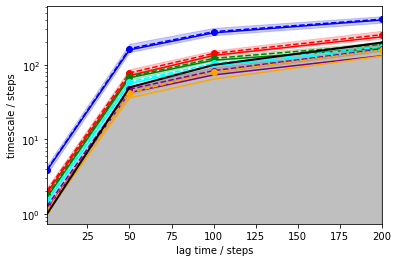

In [19]:
pyemma.plots.plot_implied_timescales(its, ylog=True);

pyemma.msm.estimators.bayesian_msm.BayesianMSM[26]: Sampling MSMs:   0%| | 0/100

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

/Users/milos/opt/anaconda3/lib/python3.9/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 97 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/Users/milos/opt/anaconda3/lib/python3.9/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 96 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/Users/milos/opt/anaconda3/lib/python3.9/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 95 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/Users/milos/opt/anaconda3/lib/python3.9/site-packages/deeptime/markov/tools/analysis/_api.py:256: UserWarning: truncated eigendecomposition to contain 93 components
  warnings.warn('truncated 

(<Figure size 720x720 with 16 Axes>,
 array([[<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='probability'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='lag time (steps)', ylabel='probability'>,
         <AxesSubplot:xlabel='lag time (steps)'>,
         <AxesSubplot:xlabel='lag time (steps)'>,
         <AxesSubplot:xlabel='lag time (steps)'>]], dtype=object))

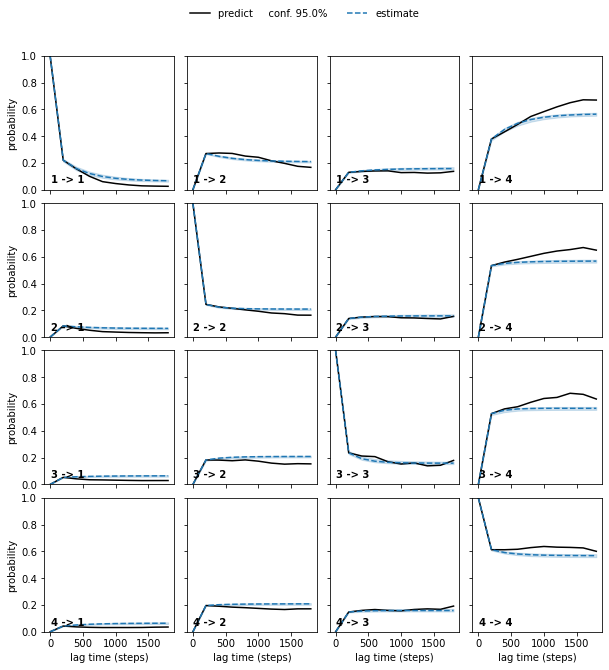

In [20]:
# To estimate msm test with error bars, use bayessian msm
msm_bayesian = pyemma.msm.bayesian_markov_model(discrete_trajectories,  lag=200)

nstates = 4
ck_msm_bayesian = msm_bayesian.cktest(nstates)
pyemma.plots.plot_cktest(ck_msm_bayesian)

In [21]:
tica_obj = pyemma.coordinates.tica(featurized_trajectory, lag=200)
tica_ouput = tica_obj.get_output()

/Users/milos/opt/anaconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /Users/milos/opt/anaconda3/lib/python3.9/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


In [22]:
time = log_padding_1_0[:,1]

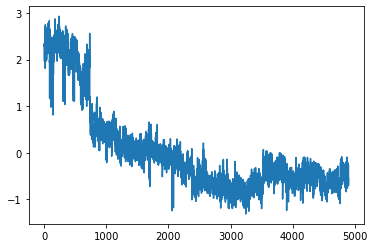

In [23]:
plt.plot(tica_ouput[0].T[0])
#the zero coordinte is not equilibrated.

In [24]:
initial_traj = md.load(pdb_file)
initial_traj.save('data/initial_petide.dcd')

In [25]:
initial_structur = pyemma.coordinates.load('data/initial_petide.dcd',features=featurizer)
crystal_tika = tica_obj.transform(initial_structur)

In [26]:
crystal_tika[0,:2]

array([0.345964 , 0.6027319], dtype=float32)

In [27]:
stationary_distribution = msm_bayesian.stationary_distribution

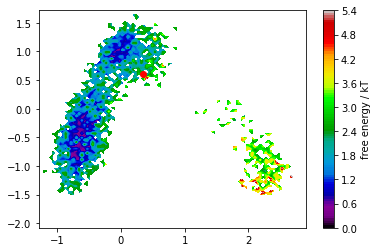

In [28]:
fig, ax = plt.subplots(1,1)
pyemma.plots.plot_free_energy(tica_ouput[0].T[0], tica_ouput[0].T[1], ax=ax 
                              ,weights=np.concatenate(msm_bayesian.trajectory_weights()))#Free energy reweighted by stationray distribution. if very differnt than not converged
ax.scatter(crystal_tika[0,0:1],crystal_tika[0,1:2],color='red')
plt.savefig('tika_free_energy.png')
#TIKA gives many coordinates, but we only use the first two.
#But we could use others
#ax.scatter(tica_obj[0].T[0][::10], tica_obj[0].T[1][::10], c=simulation_log[:,1][start:end][::10])

In [29]:
pca_obj = pyemma.coordinates.pca(featurized_trajectory, lag=200)
pca_output = pca_obj.get_output()

/Users/milos/opt/anaconda3/lib/python3.9/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "pca". Called from /Users/milos/opt/anaconda3/lib/python3.9/site-packages/decorator.py line 232. Use sklearn.decomposition.PCA instead.
  return caller(func, *(extras + args), **kw)


In [30]:
crystal_pca = pca_obj.transform(initial_structur)

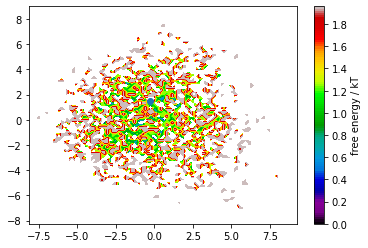

In [31]:
fig, ax = plt.subplots(1,1)
pyemma.plots.plot_free_energy(pca_output[0].T[0], pca_output[0].T[1], ax=ax )
ax.scatter(crystal_pca[0,0:1],crystal_pca[0,1:2])
#ax.scatter(tica_obj[0].T[0][::10], tica_obj[0].T[1][::10], c=simulation_log[:,1][start:end][::10])

In [32]:
nstates = 4
pcca = msm_bayesian.pcca(nstates)

/var/folders/xj/0rh3vx9d5ts_r4zwpnk3lzfr0000gn/T/ipykernel_5138/245972332.py:4: VisibleDeprecationWarning: Creating an ndarray from nested sequences exceeding the maximum number of dimensions of 32 is deprecated. If you mean to do this, you must specify 'dtype=object' when creating the ndarray.
  *np.array(traj).T,
/var/folders/xj/0rh3vx9d5ts_r4zwpnk3lzfr0000gn/T/ipykernel_5138/245972332.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  msm_bayesian.metastable_distributions[i][discrete_trajectories],


TypeError: plot_contour() missing 1 required positional argument: 'zall'

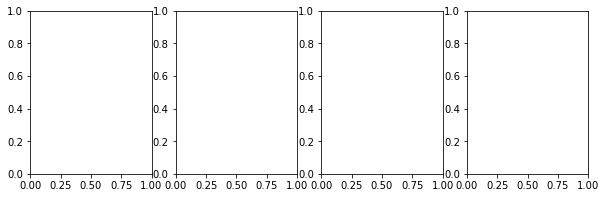

In [33]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *np.array(traj).T,
        msm_bayesian.metastable_distributions[i][discrete_trajectories],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('$\Phi$')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()
# Ref.: http://www.emma-project.org/devel/generated/05-pcca-tpt.html

In [34]:
cutoff = 0.8 # I choose 0.8, because if we look at the distribution of the dihedral angles, we can see tht the maxim of x1 and x2 is around 0.8
A = np.argwhere(msm_bayesian.metastable_memberships[:, 1] > cutoff).flatten()
B = np.argwhere(msm_bayesian.metastable_memberships[:, 2] > cutoff).flatten()

print(A)
print(B)

[]
[]


In [35]:
tpt = pyemma.msm.tpt(msm_bayesian, A.astype(int), B.astype(int))
cg, cgflux = tpt.coarse_grain(msm_bayesian.metastable_sets)

ValueError: set A or B is empty

NameError: name 'cgflux' is not defined

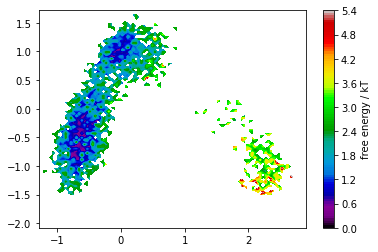

In [36]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
cs = pyemma.plots.plot_free_energy(tica_ouput[0].T[0], tica_ouput[0].T[1], ax=ax 
                              ,weights=np.concatenate(msm_bayesian.trajectory_weights()))

#fig, ax = plt.subplots(1,1)
pyemma.plots.plot_flux(
    cgflux,
    ax=ax,
    pos=np.array([[-1, 0], [0, 5/3], [1, 0],[0,0],[0,-5/3],[0.5,0.5]]),
    show_committor=False,
    figpadding=0.2,
    arrow_label_format='%2.e / ps')
# I don't know how to get the potential into the plot.

In [37]:
paths, path_fluxes = cgflux.pathways(fraction=0.99)
print('percentage       \tpath')
print('-------------------------------------')
for i in range(len(paths)):
    print(np.round(path_fluxes[i] / np.sum(path_fluxes), 3),' \t', paths[i] + 1)

NameError: name 'cgflux' is not defined